In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [83]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


 **데이터 전처리**

In [84]:
def preprocess_text(text):
    #중복 제거 및 확인
    text.drop_duplicates(subset=['document'], inplace=True)
    #document에 한 개 존재하기 때문에, 이 열을 제거
    text = text.dropna(how = 'any').reset_index(drop=True)
    #한글, 공백을 제외한 다른 문자들을 제거하는 작업
    text['document'] = text['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣\s]", "", regex=True)
    #NaN인 열을 제거
    #np.nan 즉, NaN으로 치환하고, dropna를 통해 모든 NaN열을 제거
    text['document'] = text['document'].str.replace('^ +', "", regex=True)
    text['document'].replace('', np.nan, inplace=True)
    text = text.dropna(how='any')
    return text

In [85]:
print(preprocess_text(train_data).isnull().sum())
print(preprocess_text(test_data).isnull().sum())

id          0
document    0
label       0
dtype: int64
id          0
document    0
label       0
dtype: int64


**토근화**

모델에 데이터를 넣기 위해 단어의 요소를 분해한 후, 토큰화하고 임베딩을 해야 비로소 학습시킬 수 있다.
따라서 각 문장을 토큰으로 쪼개는 작업을 거쳐야 한다. 영어는 띄어쓰기를 기준으로 해 단어를 분리하는것과 달리, 한국어는 조사와 접속사를 통해 단어를 분리한다.

e.g.
영어 : "I am a boy" -> "I", "am", "a", "boy" (o)
한국어 : 너와 나는 친구이다 -> "너와", "나는", "친구이다" (x) (띄어쓰기를 기준으로 한 경우)
             -> "너", "와", 나", "는", "친구", "이다" (o)
그래서 여기서는 konlpy라는 한국어 형태소 분석을 진행해주는 라이브러리를 사용했다. 해당 라이브러리를 사용하기 위해서는 JDK가 필요하다.

이제 불용어 : stopword를 사용해서 의미가 없는 단어들을 문장에서 삭제시킨다.
위 링크의 블로그에서 불용어로 선정한 단어 외에 여기서 단어들을 판단 하에 몇개 더 추가하여 불용어를 다음과 같이 정의했다.

In [86]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

pre_train_data = preprocess_text(train_data)
pre_test_data = preprocess_text(test_data)
tokenizer.morphs('오 많이 신기한걸 형태소 분석을 자동으로 해주다니')
# def tokenization(text):
#     tokens = tokenizer.morphs(text)  # 형태소 분석
#     tokens = [word for word in tokens if not any(char.isdigit() for char in word)]  # 숫자 제거
#     tokens = [word for word in tokens if len(word) > 1]  # 단어 길이가 2 이상인 것만 유지
#     return ' '.join(tokens)

# print(tokenization(pre_train_data[0]['document']))

from tqdm import tqdm
X_train = []
for sentence in tqdm(pre_train_data['document']):
    tokenized_sentence = tokenizer.morphs(sentence)
    stopwords_removed_sentence = [word for word in tokenized_sentence
                                  if not word in stopwords]
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [00:13<00:00, 10606.99it/s]


In [87]:
print(X_train[:3])
print(len(X_train))

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다']]
145393


In [88]:
X_test = []
for sentence in tqdm(pre_test_data['document']):
    tokenized_sentence = tokenizer.morphs(sentence)
    stopwords_removed_sentence = [word for word in tokenized_sentence
                                  if not word in stopwords]
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [00:04<00:00, 10945.83it/s]


In [89]:
print(len(X_test))

48852


**keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가**

In [57]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index)로 결과를 출력

In [59]:
#input
print(tokenizer.word_index)

{'영화': 1, '다': 2, '고': 3, '하': 4, '을': 5, '보': 6, '게': 7, '지': 8, '있': 9, '없': 10, '좋': 11, '나': 12, '었': 13, '만': 14, '는데': 15, '너무': 16, '봤': 17, '적': 18, '안': 19, '정말': 20, '로': 21, '것': 22, '음': 23, '아': 24, '네요': 25, '어': 26, '지만': 27, '재밌': 28, '같': 29, '진짜': 30, '에서': 31, '했': 32, '기': 33, '네': 34, '않': 35, '거': 36, '점': 37, '았': 38, '수': 39, '되': 40, '면': 41, 'ㅋㅋ': 42, '인': 43, '연기': 44, '말': 45, '주': 46, '내': 47, '평점': 48, '최고': 49, '이런': 50, '던': 51, '어요': 52, '할': 53, '왜': 54, '겠': 55, '스토리': 56, '해': 57, 'ㅋㅋㅋ': 58, '습니다': 59, '듯': 60, '아니': 61, '생각': 62, '드라마': 63, '더': 64, '그': 65, '사람': 66, '싶': 67, '때': 68, '감동': 69, '배우': 70, '함': 71, '본': 72, '까지': 73, '알': 74, '만들': 75, '뭐': 76, '내용': 77, '볼': 78, '보다': 79, '감독': 80, '라': 81, '그냥': 82, '재미': 83, '시간': 84, '지루': 85, '중': 86, '재미있': 87, '였': 88, '년': 89, '잼': 90, '사랑': 91, '못': 92, '냐': 93, '쓰레기': 94, '재미없': 95, '서': 96, '라고': 97, '니': 98, '면서': 99, '다시': 100, '번': 101, '나오': 102, '하나': 103, '작품': 104, '이거': 105, '야': 1

In [60]:
#input
print(len(tokenizer.word_index))

49946


3번 미만으로 사용된 단어의 개수와 빈도를 전체 단어의 개수와 빈도수의 비율

In [61]:
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('size of vocabulary set: ', total_cnt)
print('# of voca that appears less than %s: %s' % (threshold - 1, rare_cnt))
print('ratio of voca that appears less than 2: ', (rare_cnt/total_cnt)*100)
print('ratio of voca freq that appears less than 2: ', (rare_freq/total_freq)*100)

size of vocabulary set:  49946
# of voca that appears less than 2: 28324
ratio of voca that appears less than 2:  56.709245985664516
ratio of voca freq that appears less than 2:  1.7647314442467037


3번 미만으로 나타난 단어의 개수는 전체 단어 개수의 약 55%였지만, 빈도 수는 1.8%정도에 불과했다. 해당 값들은 크게 의미가 있지 않은 단어라고 판단했다.
앞서 tokenizer의 단어의 순서는 빈도수이기 때문에, 해당하는 24337개의 단어를 전체 단어에서 뺀 값을 단어의 개수로 사용하겠다.

In [63]:
#input
vocab_size = total_cnt - rare_cnt + 1
print('size of vocavulary :', vocab_size)

size of vocavulary : 21623


In [10]:
#중복 없는 갯수 확인(146183,)
train_data['document'].unique().shape
#중복 제거 및 확인
train_data.drop_duplicates(subset=['document'], inplace=True)
print("# of train data: ", len(train_data))

# of train data:  146183


이제 토큰화 한 단어를 사용해서 X_train_seq와 X_test_seq를 만들었다.

In [93]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [96]:
print(len(X_train_seq))
print(len(X_test_seq))

145393
48852


리뷰의 타겟 값도 train_df['label']에서 분리하여 만든다.

In [98]:
y_train = np.array(pre_train_data['label'])
y_test = np.array(pre_test_data['label'])
print(len(y_train))
print(len(y_test))

145393
48852


**데이터셋 내 문장 길이 분포**

Text(0, 0.5, 'number of samples')

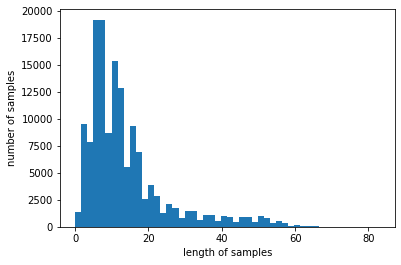

In [105]:
import matplotlib.pyplot as plt
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

히스토그램으로 봤을때 30~40 보다 길이가 긴 경우는 많이 없다고 간주할 수 있다.
이를 수치화하여 확인해보자.

In [100]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            cnt = cnt + 1
    ratio = (cnt/len(nested_list))*100
    return ratio

**적절한 최대 문장 길이 지정**

range(10, 110, 10)


Text(0, 0.5, 'ratio of samples')

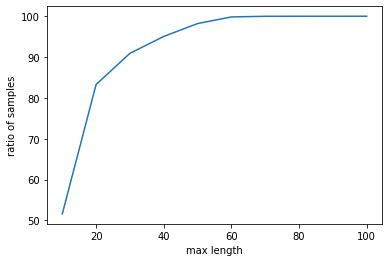

In [101]:
arr = range(10, 110, 10)
print(arr)
ratios = []

for max_len in arr:
    ratios.append(below_threshold_len(max_len, X_train_seq))

plt.plot(arr, ratios)
plt.xlabel('max length')
plt.ylabel('ratio of samples')

영어의 기준에서는 동사가 주로 앞에 나오는 경우가 많다. 간단하게 말하면 결론이 앞에 온다는 것이다.(반대로 한국어는 끝까지 들어야 한다는 말처럼, 끝부분에 관형사가 오기에 끝부분이 전체 내용을 좌우할 수 있다) 간단한 영작으로 "나는 이 영화가 좋다"라는 문장을 보면
"I like this movie."라고 적을 수 있다. 그렇다면, 다음과 같이 문장에 조금 더 살을 붙여 보자.
"저는 이 영화가 공포스러운 장면이 너무 많고 잔인한 장면이 많긴 하지만 흥미로워서 좋아요!"라는 문장을 생각해보면,
"I like this movie 'cause It's very interesting, Although has some scary and gross scenes"라고 영작할 수 있다(제 처참한 영작 실력은 무시해주세요!)
이 경우 만일 padding='pre'로 문장을 자른다고 하면
한글 문장은 : "저는 이 영화가 공포스러운 장면이 너무 많고 잔인한"
영어 문장은 : "I like this movie cause It's very interesting, "
정도로 잘라 질 수 있다. 한글 문장의 경우 영화가 공포스러운 장면이 많고 너무 잔인하다 라는 내용으로 동사나 형용사를 어림잡아야 하는 반면, 영어 문장은 결론(like)이 앞에 나와있기 때문에 긍정적인 문장으로 판단할 수 있다.
따라서 이 예제와 같은 한국어 문장을 판단하는 경우에는 padding='post'로 설정하는게 낫겠다는 결론을 내렸다.

In [102]:
X_train_40 = pad_sequences(X_train_seq, maxlen=40, padding='post')
X_test_40 = pad_sequences(X_test_seq, maxlen=40, padding='post')
print(len(X_train_40))
print(len(X_test_40))

145393
48852


**모델 훈련 개시**

In [103]:
import keras
model5 = keras.Sequential()
model5.add(keras.layers.Embedding(vocab_size, 100))
model5.add(keras.layers.LSTM(128, dropout=0.3))
model5.add(keras.layers.Dense(1, activation='sigmoid'))

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-sentiment-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model5.fit(X_train_40, y_train, epochs=30, callbacks=[checkpoint_cb, early_stopping_cb],
                    validation_split=0.2, batch_size=64)

Epoch 1/30
1818/1818 [==============================] - 12s 6ms/step - loss: 0.4279 - accuracy: 0.7914 - val_loss: 0.3606 - val_accuracy: 0.8433
Epoch 2/30
1818/1818 [==============================] - 10s 5ms/step - loss: 0.3090 - accuracy: 0.8690 - val_loss: 0.3338 - val_accuracy: 0.8538
Epoch 3/30
1818/1818 [==============================] - 10s 6ms/step - loss: 0.2623 - accuracy: 0.8918 - val_loss: 0.3500 - val_accuracy: 0.8520
Epoch 4/30
1818/1818 [==============================] - 10s 5ms/step - loss: 0.2271 - accuracy: 0.9074 - val_loss: 0.3611 - val_accuracy: 0.8522
Epoch 5/30
1818/1818 [==============================] - 10s 5ms/step - loss: 0.1994 - accuracy: 0.9209 - val_loss: 0.4066 - val_accuracy: 0.8527


**Loss, Accuracy 그래프 시각화**

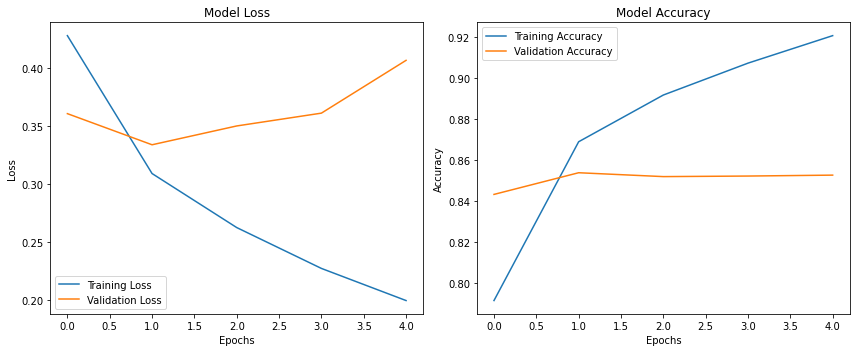

In [107]:
# 훈련 결과 시각화
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

best_model을 불러와서 test set으로 가져온 모델을 최종적으로 평가해보면

In [104]:
best_model = keras.models.load_model('best-sentiment-model.h5')
best_model.evaluate(X_test_40, y_test)

1527/1527 [==============================] - 4s 2ms/step - loss: 0.4140 - accuracy: 0.8515


[0.41401389241218567, 0.8514901995658875]

**결론**
적절한 전처리와 딕서너리를 잘 생성하고, 한국어를 감안하여 post 방식으로 패딩 한 것이 나름의 성능에 기여 한 것 같습니다.

In [ ]:
**회고**
데이터 분석하고, 전처리 부분에 시간 할당이 많아 뒤 부분 나머지 평가 지표를 진행 하지 못했지만, 프로젝트를 통해 좀 더 이해의 폭을 넓혀 만족 합니다.

In [ ]:
**아쉬운 점 & 보완책**
한국어 Word2Vec 임베딩 활용하여 성능 개선 하는 부분/ 다른 모델 2개에 대한 비교를 진행 하지 못하여 아쉬었습니다.
제출 이후에도 이 부분에 대해 좀 더 진행 할 생각 입니다.